In [0]:
import torch
import torchvision

import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

In [16]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

cifar_train = torchvision.datasets.CIFAR10('./cifardata', train=True, download=True, 
                                           transform=transform)
cifar_test = torchvision.datasets.CIFAR10('./cifardata', train=False, download=True, 
                                          transform=transform)

channels, width, height = cifar_train[0][0].size()

train_flattened = [(x.view(channels * width * height), y) 
                   for x, y in cifar_train]
test_flattened = [(x.view(channels * width * height), y) 
                  for x, y in cifar_test]

data_train = train_flattened[:40000]
data_val = train_flattened[40000:]
data_test = test_flattened

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

batch_size = 16

trainloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                          num_workers=2)
valloader = torch.utils.data.DataLoader(data_val, batch_size=batch_size,
                                          num_workers=2)
testloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size,
                                          num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
class CifarNN(nn.Module):
    
    def __init__(self):
        super(CifarNN, self).__init__()
        self.input = nn.Linear(3072, 5000, bias=False)
        self.input_bn = nn.BatchNorm1d(5000)
        
        self.hidden1 = nn.Linear(5000, 2000, bias=False)
        self.dropout1 = nn.Dropout()
        self.hidden1_bn = nn.BatchNorm1d(2000)
        
        self.hidden2 = nn.Linear(2000, 800, bias=False)
        self.dropout2 = nn.Dropout()
        self.hidden2_bn = nn.BatchNorm1d(800)
        
        self.hidden3 = nn.Linear(800, 300, bias=False)
        self.hidden3_bn = nn.BatchNorm1d(300)
        
        self.hidden4 = nn.Linear(300, 50, bias=False)
        self.hidden4_bn = nn.BatchNorm1d(50)
        
        self.output = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(self.input_bn(self.input(x)))
        x = self.dropout1(F.relu(self.hidden1_bn(self.hidden1(x))))
        x = self.dropout2(F.relu(self.hidden2_bn(self.hidden2(x))))
        x = F.relu(self.hidden3_bn(self.hidden3(x)))
        x = F.relu(self.hidden4_bn(self.hidden4(x)))
        x = self.output(x)
        return x

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
model = CifarNN()
model.to(device)
model_path = './best_dnn.tar'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

train_losses = []
val_losses = []
n_epochs = 10
eval_freq = 500
num_evals = 0
best_num_evals = 0
patience = 3 * eval_freq
early_stop = False

for epoch in range(10):
    running_loss = 0.0
    val_iters_improved = 0
    
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        # forward, backward, optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics and early stopping every 500 examples
        running_loss += loss.item()
        if i % eval_freq == eval_freq - 1:
            num_evals += 1
            
            # evaluate average validation loss
            running_val_loss = 0.0
            for val_data in valloader:
                val_inputs, val_labels = val_data
                val_inputs = val_inputs.to(device)
                val_labels = val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = nn.CrossEntropyLoss()(val_outputs, val_labels)
                running_val_loss += val_loss.item()
            val_losses.append(running_val_loss / 10000) 
            
            # compute average training loss
            train_losses.append(running_loss / (eval_freq * batch_size))
            running_loss = 0.0
            
            # print statistics
            print('[%d, %5d] train loss: %.3f\tval loss: %.3f' %
                  (epoch + 1, i + 1, train_losses[-1], val_losses[-1]))
            
            # save model params if validation loss went down
            val_iters_improved += eval_freq
            if min(val_losses) == val_losses[-1]:
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss
                    }, model_path)
                val_iters_improved = 0
                best_num_evals = num_evals
                
            # load older model and end training 
            elif val_iters_improved > patience:
                print('Eraly stopping criterion reached')
                checkpoint = torch.load(model_path)
                model.load_state_dict(checkpoint['model_state_dict'])
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
                epoch = checkpoint['epoch']
                loss = checkpoint['loss']
                num_evals = best_num_evals
                early_stop = True
                
        # break if we have seen early stopping criterion
        if early_stop:
            break

print('Finished Training')

[1,   500] train loss: 0.126	val loss: 0.118
[1,  1000] train loss: 0.116	val loss: 0.114
[1,  1500] train loss: 0.112	val loss: 0.112
[1,  2000] train loss: 0.108	val loss: 0.110
[1,  2500] train loss: 0.109	val loss: 0.108
[2,   500] train loss: 0.106	val loss: 0.105
[2,  1000] train loss: 0.104	val loss: 0.105
[2,  1500] train loss: 0.102	val loss: 0.105
[2,  2000] train loss: 0.100	val loss: 0.104
[2,  2500] train loss: 0.100	val loss: 0.103
[3,   500] train loss: 0.098	val loss: 0.101
[3,  1000] train loss: 0.097	val loss: 0.101
[3,  1500] train loss: 0.094	val loss: 0.102
[3,  2000] train loss: 0.094	val loss: 0.102
[3,  2500] train loss: 0.094	val loss: 0.101
[4,   500] train loss: 0.092	val loss: 0.099
[4,  1000] train loss: 0.092	val loss: 0.100
[4,  1500] train loss: 0.090	val loss: 0.102
[4,  2000] train loss: 0.089	val loss: 0.100
[4,  2500] train loss: 0.089	val loss: 0.099
[5,   500] train loss: 0.087	val loss: 0.098
[5,  1000] train loss: 0.087	val loss: 0.099
[5,  1500]

Text(0, 0.5, 'Log-Loss')

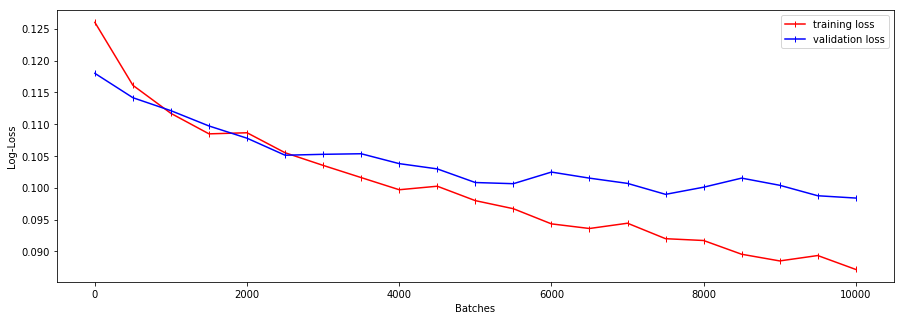

In [20]:
fig = plt.figure(figsize=(15,5))
plt.plot(np.arange(0, num_evals * eval_freq, eval_freq), 
         train_losses[0:num_evals], color='r', marker='|')
plt.plot(np.arange(0, num_evals * eval_freq, eval_freq), 
         val_losses[0:num_evals], color='b', marker='|')
plt.legend(['training loss', 'validation loss'])
plt.xlabel('Batches')
plt.ylabel('Log-Loss')

In [22]:
# Evaluate Validation accuracy
model.eval()
running_correct = 0
for data in valloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = nn.Softmax(dim=1)(outputs).max(1)
    correct = torch.sum(torch.eq(preds, labels))
    
    running_correct += correct
    
print('Validation Acc: %.3f' % 
      (running_correct.item() / (len(valloader) * batch_size)))
    

Validation Acc: 0.496


In [23]:
# Evaluate Test accuracy
model.eval()
running_correct = 0
for data in testloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, preds = nn.Softmax(dim=1)(outputs).max(1)
    correct = torch.sum(torch.eq(preds, labels))
    
    running_correct += correct
    
print('Test Acc: %.3f' % 
      (running_correct.item() / (len(valloader) * batch_size)))
    

Test Acc: 0.499
